# Feature Engineering 

The purpose of this notebook is to implement and analyze different feature vectors: HOGs, LBPs, LBP-based implementation of delta-T, and segmentation features as described in the Capstone writeup. 

The notebook also performs model selection, hyperparameter tuning, and feature selection. The performance of the final machine learning model is compared to the automated version of the human-evaluation method as described in Gonzalez (2011.) 

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Histogram-of-Oriented-Gradients" data-toc-modified-id="Histogram-of-Oriented-Gradients-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Histogram of Oriented Gradients</a></span><ul class="toc-item"><li><span><a href="#Dimensionality-Reduction-Techniques-Comparison" data-toc-modified-id="Dimensionality-Reduction-Techniques-Comparison-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Dimensionality Reduction Techniques Comparison</a></span><ul class="toc-item"><li><span><a href="#Locality-Preserving-Projections" data-toc-modified-id="Locality-Preserving-Projections-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Locality Preserving Projections</a></span></li><li><span><a href="#FastICA" data-toc-modified-id="FastICA-1.1.2"><span class="toc-item-num">1.1.2&nbsp;&nbsp;</span>FastICA</a></span></li><li><span><a href="#PCAs-with-different-Kernels" data-toc-modified-id="PCAs-with-different-Kernels-1.1.3"><span class="toc-item-num">1.1.3&nbsp;&nbsp;</span>PCAs with different Kernels</a></span></li></ul></li><li><span><a href="#HOG-Feature-Vector" data-toc-modified-id="HOG-Feature-Vector-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>HOG Feature Vector</a></span></li></ul></li><li><span><a href="#Local-Binary-Patterns" data-toc-modified-id="Local-Binary-Patterns-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Local Binary Patterns</a></span><ul class="toc-item"><li><span><a href="#Implementation" data-toc-modified-id="Implementation-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Implementation</a></span></li></ul></li><li><span><a href="#LBP-Based-Delta-Ts" data-toc-modified-id="LBP-Based-Delta-Ts-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>LBP-Based Delta-Ts</a></span></li><li><span><a href="#Segmentation-Features" data-toc-modified-id="Segmentation-Features-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Segmentation Features</a></span></li><li><span><a href="#Create-Datasets" data-toc-modified-id="Create-Datasets-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Create Datasets</a></span></li><li><span><a href="#Feature-Selection-with-SHAP" data-toc-modified-id="Feature-Selection-with-SHAP-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Feature Selection with SHAP</a></span></li><li><span><a href="#Algorithm-Selection" data-toc-modified-id="Algorithm-Selection-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Algorithm Selection</a></span></li><li><span><a href="#Hyperparameter-Tuning" data-toc-modified-id="Hyperparameter-Tuning-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Hyperparameter Tuning</a></span></li><li><span><a href="#Final-Analysis-on-the-Test-Set" data-toc-modified-id="Final-Analysis-on-the-Test-Set-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Final Analysis on the Test Set</a></span></li></ul></div>

In [1]:
# Environment Setup
from utils import *

Progress: [###################-] 97.3%


## Histogram of Oriented Gradients

In [2]:
def get_hog(temps,
            orientations=4,
            pixels_per_cell=(12,12),
            cells_per_block=(4,4),
            block_norm='L1-sqrt',
            vis=False):
    ''' Compute HOGs of the exploration ROIs.

    Parameters
    ----------
    temps: string or list
         Patient ID or
         list of ROI-masked temperatures in l, lf, r, rl order.
    orientations: int
         Number of orientation bins.
    pixels_per_cell: 2-tuple (int, int), optional
         Size (in pixels) of a cell.
    cells_per_block: 2-tuple (int, int), optional
         Number of cells in each block.
    block_norm: {'L1', 'L1-sqrt', 'L2', 'L2-Hys'}, optional
         Block normalization method.
    vis: bool optional
         Return an image of the HOG.
         For each cell and orientation bin, the image contains a
         line segment that is centered at the cell center,
         is perpendicular to the midpoint of the range of angles spanned
         by the orientation bin, and has intensity proportional to the
         corresponding histogram value.

    Returns
    -------
    hog_features: list[nd array]
         List of HOG descriptors for the input images:
         a 1D (flattened) array.
    '''
    # Make sure the exploration is valid
    if len(temps) != 4:
        raise ValueError(f'{temps} is not a valid exploration')
    
    hog_features = []
    if vis:
        hog_visuals = []
        for temp in temps:
            # Get HOG feature vector + visuals
            temp = np.nan_to_num(temp)
            
            hog_feature_vect, hog_vis = hog(temp,orientations,
                                            pixels_per_cell,
                                            cells_per_block,
                                            block_norm,
                                            visualize=vis)
            hog_features.append(hog_feature_vect)
            hog_vis[hog_vis==0] = np.nan
            hog_visuals.append(hog_vis)
        return hog_features, hog_visuals
    else:
        for temp in temps:
            temp = np.nan_to_num(temp)
            # Get HOG feature vector
            hog_feature_vect = hog(temp,
                                   orientations=orientations,
                                   pixels_per_cell=pixels_per_cell,
                                   cells_per_block=cells_per_block,
                                   block_norm=block_norm,
                                   visualize=vis,
                                   multichannel=False,
                                   feature_vector=True)
            hog_features.append(hog_feature_vect)
        return hog_features

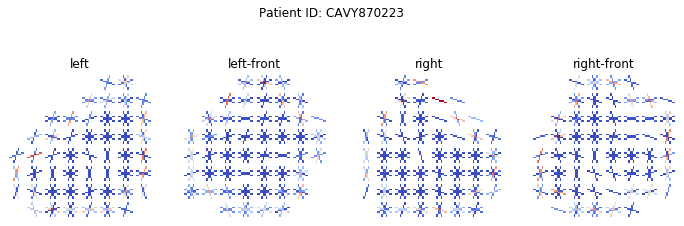

In [3]:
# Plot example HOGs
plt.rcParams['image.cmap'] = 'coolwarm'
idx = np.random.randint(0,len(temps))
_, vis_hogs = get_hog(temps[idx], vis=True)
np.array(vis_hogs).shape

plot_exp(vis_hogs, IDs[idx])

In [4]:
# Extract feature vector
hogs = [np.array(get_hog(temp)).flatten() for temp in temps]
hog_data = pd.DataFrame(hogs)
hog_data.index = IDs
hog_data['BIRADS'] = birads

# Subset positive indices
pos_ids = hog_data.index[hog_data.BIRADS>3]

In [5]:
# Extract feature vector for unlabeled observations
blind_hogs = [np.array(get_hog(temp)).flatten() for temp in blind_temps]
blind_hog_data = pd.DataFrame(blind_hogs)
blind_hog_data.index = blind_IDs
blind_hog_data['BIRADS'] = blind_birads

# Subset positive indices
blind_pos_ids = blind_hog_data.index[blind_hog_data.BIRADS>3]

In [6]:
# Split data into train and test set
X_train, X_test, y_train, y_test = train_test_split(
    hog_data.loc[:, hog_data.columns!='BIRADS'], 
    hog_data.BIRADS, test_size=0.2, random_state=1)

# Subset the validation set
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.25, random_state=1)

# Get binary targets
y_train_bi = np.where(y_train>3, 1, 0)
y_test_bi = np.where(y_test>3, 1, 0)
y_val_bi = np.where(y_val>3, 1, 0)

print(len(y_train), len(y_val), len(y_test))

1116 372 373


### Dimensionality Reduction Techniques Comparison

In [7]:
# Helper functions
def get_components(method, 
                   n_comp, 
                   train_set, 
                   test_set, 
                   val_set,
                   name, kernel=None, 
                   blind_data=None):
    ''' Perform dimensionality reduction.

    Parameters
    ----------
    method: object
         Name of the dimensionality
         reduction method (KernelPCA, 
                           FastICA, 
                           LocalityPreservingProjection)
    n_comp: int
         Number of output components

    train_set: pandas DataFrame
         Training data with the HOG feature vector
    test_set: pandas DataFrame
         Testing data with the HOG feature vector
    val_set: pandas DataFrame
         Validation data with the HOG feature vector
    name: str
         Name of the dimensionality reduction method
    kernel: str (optional)
         A kernel that is used for kernel PCA methods
    blind_data: pandas DataFrame (optional)
         A dataframe with unlabeled data

    Returns
    -------
        Two transformed dataframes: one for train, one for test
        A dataframe with features extracted from unlabeled data (optional)
    '''
    if kernel:
        dim_red = method(n_components=n_comp, kernel=kernel)
    else:
        dim_red = method(n_components=n_comp)
    
    # Make sure there is no data leakage
    train_comps = dim_red.fit_transform(train_set)
    test_comps = dim_red.transform(test_set)
    val_comps = dim_red.transform(val_set)
    
    df_train = pd.DataFrame(train_comps, 
                            columns =[name +str(i+1) for i in range(len(train_comps[0]))])
    df_test = pd.DataFrame(test_comps, 
                           columns =[name +str(i+1) for i in range(len(test_comps[0]))])
    df_val = pd.DataFrame(val_comps, 
                           columns =[name +str(i+1) for i in range(len(val_comps[0]))])
    
    df_test.index = test_set.index.values
    df_train.index = train_set.index.values
    df_val.index = val_set.index.values
    df_test.index.name = 'pid'
    df_train.index.name = 'pid'
    df_val.index.name = 'pid'
    if blind_data is not None:
        blind_comps = dim_red.transform(blind_data)
        df_blind = pd.DataFrame(blind_comps, 
                                columns =[name +str(i+1) for i in range(len(blind_comps[0]))])
        df_blind.index = blind_data.index.values
        df_blind.index.name = 'pid'
        return df_train, df_test, df_val, df_blind
    return df_train, df_test, df_val

In [8]:
def get_stats(healthy, cancer):
    ''' Get dataframes with healthy and cancer patients.

    Inputs
    ----------
    healthy: pandas dataframe
       Dataframe with healthy patients' data

    cancer: pandas dataframe
       Dataframe with cancer patients' data

    Returns
    -------
       Dataframe with t-values and statistics for each feature
    '''
    features = [feat for feat in healthy.columns]
    sd_h = [np.std(healthy[feat]) for feat in healthy.columns]
    sd_c = [np.std(cancer[feat]) for feat in healthy.columns]
    mean_h = [np.mean(healthy[feat]) for feat in healthy.columns]
    mean_c = [np.mean(cancer[feat]) for feat in healthy.columns]
    t_val = [ttest_ind(healthy[feat], cancer[feat])[0] for feat in healthy.columns]
    p_val = [ttest_ind(healthy[feat], cancer[feat])[1] for feat in healthy.columns]

    statistics = pd.DataFrame({'Feature Name':features,
                               'Mean Healthy':mean_h,
                               'Mean Cancer':mean_c,
                               'SD_Healthy':sd_h,
                               'SD_Cancer':sd_c,
                               'p-value':p_val, 
                               't-value':t_val})
    statistics = statistics.reindex(statistics['t-value'].abs().sort_values(ascending=False).index)
    return statistics

In [9]:
def plot_dim_red(aucs, max_comp, best=False, 
                 title='',best_aucs=[]):
    '''
    Plot a set of AUC scores for dimensionality 
    reduction techniques.

    Inputs
    ----------
    aucs: list
         List of AUC scores
    max_comp: int
         Maximum number of components 
    best: bool
         Indicator of whether best components should be calculated
    title: str
         Plot title
    best_aucs: list
         Best AUC scores that are required for best components

    Returns
    -------
    Plot of AUC values
    Maximum AUC score
    '''
    if best:
        fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12, 4))
        ax1.plot(range(2,max_comp),aucs)
        ax1.set_xlabel('Number of Components')
        ax1.set_ylabel('Average AUC over 100 Runs')
        ax1.set_title(title)
        
        ax2.plot(range(2,max_comp),best_aucs)
        ax2.set_xlabel('Number of Components')
        ax2.set_ylabel('Average AUC over 100 Runs')
        ax2.set_title('Best N Components')
        print('Max AUC: ', max(best_aucs))
        return max(best_aucs)
    else:
        plt.plot(range(2,max_comp),aucs)
        plt.xlabel('Number of Components')
        plt.ylabel('Average AUC over 100 Runs')
        plt.title(title)
        plt.show()
        print('Max AUC: ', max(aucs))
        return max(aucs)

In [10]:
def eval_dim_red(max_comp, X_train, X_test, 
              y_train, y_test, label, 
              best=False, stats=None, blind=None):
    ''' 
    Evaluate dimensionality reduction techniques
    with different number of components.

    Inputs
    ----------
    max_comp: int
         Maximum number of components 
    X_train: dataframe or numpy array
         Training set with reduced features
    X_test: dataframe or numpy array
         Test set with reduced features
    y_train: np.array
         Training targets    
    y_test: np.array
         Test targets  
    label: str
         A plot title
    best: bool
         Whether to pick features with best t-values
    stats: dataframe
         Output of the get_stats function
    blind: dataframe or numpy array
         Unlabelled data with reduced features
        
    Returns
    -------
    Plot of AUC values
    '''
    aucs = []
    best_aucs = []
    for i in range(2, max_comp):
        if best:
            best_comps = stats['Feature Name'][:i].values
            train_best = X_train[best_comps]
            test_best = X_test[best_comps]
            if blind is not None:
                blind_best = blind[best_comps]
            # Average over 100 runs to get robust result
            best_auc = [(performance(train_best, y_train, test_best, y_test)) for i in range(100)]
            best_aucs.append(np.mean(best_auc))
        
        train = X_train.iloc[:, 0:i]
        test = X_test.iloc[:, 0:i]
            
        auc = [(performance(train, y_train, test, y_test)) for i in range(100)]
        aucs.append(np.mean(auc))
        
    return plot_dim_red(aucs, max_comp, best, label, best_aucs)

#### Locality Preserving Projections

LPPs are linear projective maps that are obtained by finding the optimal linear approximations to the eigenfunctions of the Laplace Beltrami operator on the manifold.

In [11]:
train_lpp, _, val_lpp = get_components(LocalityPreservingProjection,
                                       30, X_train, X_test, 
                                       X_val, 'LPP')

healthy_lpp = train_lpp[train_lpp.index.isin(pos_ids)]
cancer_lpp = train_lpp[~train_lpp.index.isin(pos_ids)]

stats_lpp = get_stats(healthy_lpp, cancer_lpp)

# Show components with the highest t-scores
stats_lpp.head()

,Feature Name,Mean Healthy,Mean Cancer,SD_Healthy,SD_Cancer,p-value,t-value
18,LPP19,-3.502472e-08,-1.042012e-09,1.235872e-07,1.163932e-07,0.019575,-2.337774
13,LPP14,-3.988002e-08,8.443173e-10,1.288279e-07,1.664460e-07,0.046656,-1.991626
29,LPP30,3.448466e-08,3.080652e-09,1.314280e-07,1.280918e-07,0.049364,1.967582
2,LPP3,-8.372139e-08,2.841552e-08,4.387749e-07,4.841178e-07,0.061422,-1.872338
0,LPP1,-2.209217e-07,1.237635e-08,9.882756e-07,1.161531e-06,0.103696,-1.628527


Max AUC:  0.4974461193472032


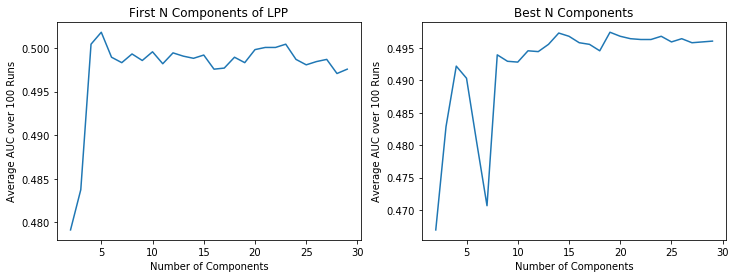

In [12]:
res_lpp = eval_dim_red(30, train_lpp, val_lpp, y_train_bi, 
                       y_val_bi, 'First N Components of LPP', 
                       best=True, stats = stats_lpp)

#### FastICA

Max AUC:  0.7869565217391302


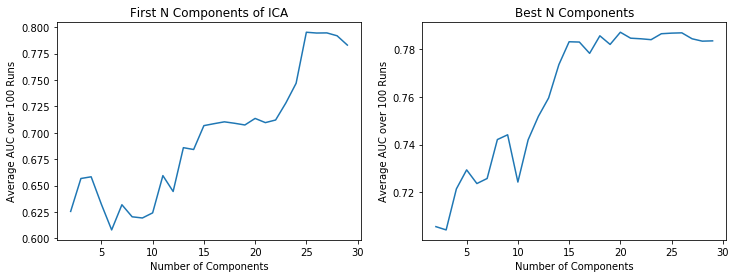

In [13]:
train_ica, test_ica, val_ica = get_components(FastICA, 30, X_train, 
                                              X_test, X_val, 'HOG')

healthy_ica = train_ica[train_ica.index.isin(pos_ids)]
cancer_ica = train_ica[~train_ica.index.isin(pos_ids)]

stats_ica = get_stats(healthy_ica, cancer_ica)
auc_ica = eval_dim_red(30, train_ica, test_ica, y_train_bi, 
                       y_test_bi, 'First N Components of ICA', 
                       best=True, stats=stats_ica)

#### PCAs with different Kernels

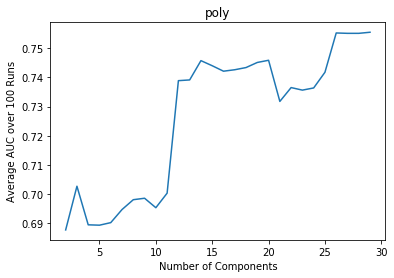

Max AUC:  0.7554503550517008


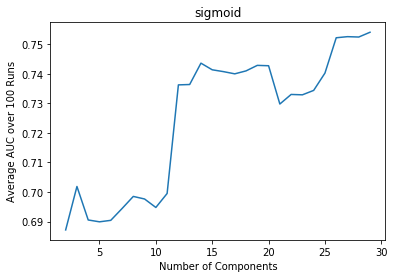

Max AUC:  0.7540799800672728


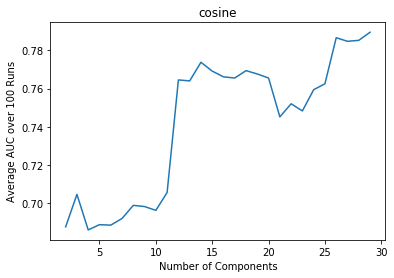

Max AUC:  0.7894605705743115


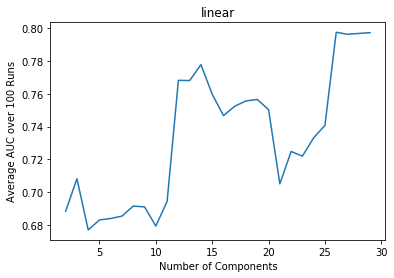

Max AUC:  0.7976828204808768


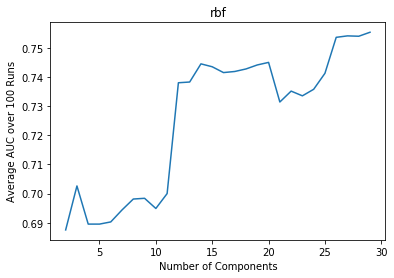

Max AUC:  0.7553257755076614
Best Kernel:  linear


In [14]:
kernels = ['poly', 'sigmoid', 'cosine','linear', 'rbf']
best_kernel, best_auc = np.nan, 0
for k in kernels:
    train, _, val = get_components(KernelPCA,
                                   30, X_train, 
                                   X_test, X_val, 
                                   k, kernel=k)
    auc_temp = eval_dim_red(30, train, val, 
                            y_train_bi, 
                            y_val_bi, label=k)
    if auc_temp > best_auc:
        best_auc, best_kernel = auc_temp, k
if auc_ica > best_auc:
    best_kernel = FastICA
print('Best Kernel: ', best_kernel)

### HOG Feature Vector

In [15]:
# Linear PCA seems to consistently outperform non-linear kernel methods
train_red, test_red, val_red, blind_red = get_components(KernelPCA,
                                         30, X_train, X_test, X_val, 'HOG', 
                                         blind_data=blind_hog_data.drop(columns=['BIRADS']),
                                         kernel=best_kernel)

In [16]:
df_full = pd.DataFrame(np.vstack([train_red, test_red, val_red]), 
                       columns=train_red.columns)

pids_full = np.hstack([X_train.index.values, 
                       X_test.index.values, 
                       X_val.index.values])
df_full['IDs'] = pids_full


df_blind = blind_red
df_blind['IDs'] = df_blind.index.values

In [17]:
# Example of the HOG vector
df_full.head()

,HOG1,HOG2,HOG3,HOG4,HOG5,HOG6,HOG7,HOG8,HOG9,HOG10,...,HOG22,HOG23,HOG24,HOG25,HOG26,HOG27,HOG28,HOG29,HOG30,IDs
0,-1.371565,0.807489,-2.254251,1.007360,-0.092994,0.657385,0.221389,1.180854,-0.246951,-1.301451,...,-0.388234,-0.271076,0.023689,0.743722,-0.236737,0.528036,0.496687,-0.613981,-0.129885,RADL820324
1,-1.502152,0.069987,-1.418895,-1.127319,0.605097,2.513478,0.396302,-0.151165,0.435440,0.632690,...,-0.653363,-0.028287,-0.241648,-0.261914,0.499174,-0.129508,-0.982390,-0.352028,-0.635519,SAMG850909
2,-1.940585,1.966867,-0.374716,-2.169323,-0.599983,0.120350,-0.436862,0.850089,0.000835,-0.416110,...,-1.274984,0.850851,0.356479,1.250388,0.399026,1.116652,0.262785,0.140903,-1.365428,DICA971030
3,-1.034237,0.335155,-1.815421,-0.181717,-0.327546,-1.029567,-1.374261,0.634037,-2.032316,0.246734,...,-0.051184,-0.209648,0.060540,0.410771,0.702067,-1.318880,0.579644,0.628786,0.106095,MEMR750609
4,-0.461621,1.150660,-1.282628,-1.273359,1.193648,0.883413,1.095596,0.523819,-0.865364,0.436860,...,0.324187,0.067772,0.304306,0.495568,0.456985,-0.567885,0.450965,-0.276796,0.081339,ROGC760606


## Local Binary Patterns
### Implementation

In [18]:
def get_lbp(temps,num_points=24,
            radius=2, hist=False):
    '''Compute LBP features of the exloration's ROIs.

    LBPs are masked with an eroded version of the ROI mask to reduce boundary
    artifacts due to the discontinuity of the ROI.

    Parameters
    ----------
    temps: string or list
           Patient ID or
           list of ROI-masked temperatures in l, lf, r, rl order.
    num_points: int, optional
           Number of circularly symmetric neighbour set points
           (quantization of the angular space) of the LBP operator.

    radius: float, optional
           Radius of circle (spatial resolution of the LBP operator).
    hist: bool
           Indicates whether to return a reduced vector or all values
           
    Returns
    -------
    lbps: list[nd array]
          List of global LBP histograms of ROI-masked temperatures
          in l, lf, r, rl order.
    '''
    if len(temps) != 4:
        raise ValueError('Not a valid exploration')

    lbps = []
    for temp in temps:
        # Obtain a masked array.
        temp_nan = temp.copy()
        temp_nan[~np.isnan(temp_nan)] = 1

        # Compute an eroded mask array to remove boundary effects
        kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (3, 3))
        temp_nan_erode = np.nan_to_num(temp_nan)
        temp_nan_erode = cv2.erode(temp_nan_erode, kernel=kernel, iterations=3)
        temp_nan_erode[temp_nan_erode == 0] = np.nan
        # Compute lbp and histogram
        temp_lbp = local_binary_pattern(temp,
                                        P=num_points,
                                        R=radius,
                                        method='uniform')
        temp_lbp *= temp_nan_erode
        if hist:
            lbp_hist, _ = np.histogram(temp_lbp[~np.isnan(temp_lbp)],
                                       density=False, bins=9, range=(0, 9))
            lbp_hist = lbp_hist/(lbp_hist.sum()+1e-10)
            lbps.append(lbp_hist)

        else:
            lbps.append(temp_lbp)
    if hist:
        breasts = int(len(lbps)/2)
        right = sum(lbps[:breasts])/len(lbps[:breasts])
        left = sum(lbps[breasts:])/len(lbps[breasts:])
        lbps = right- left
    return lbps

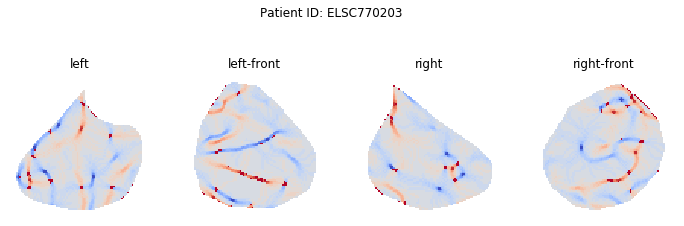

In [19]:
# Example LBPs
idx = np.random.choice(len(temps))
lbps = get_lbp(temps[idx])
plot_exp(lbps, IDs[idx])

In [20]:
lbp_data = [np.array(get_lbp(temp, hist=True)).flatten() for temp in temps]

lbp_data = pd.DataFrame(lbp_data,columns =['LBP' +str(i+1) for i in range(0,9)])
lbp_data['IDs'] = IDs

In [21]:
lbp_blind = [np.array(get_lbp(temp, hist=True)).flatten() for temp in blind_temps]

lbp_blind = pd.DataFrame(lbp_blind,columns =['LBP' +str(i+1) for i in range(0,9)])
lbp_blind['IDs'] = blind_IDs

In [22]:
df_full = pd.merge(df_full, lbp_data, how="left", on='IDs')
df_blind = pd.merge(df_blind, lbp_blind, how="left", on='IDs')

## LBP-Based Delta-Ts

In [23]:
def temps_LBPs(loc, maxim, lbp_plot, inv):
    '''Plot temperature maps and their corresponding LBPs.
    
    Parameters
    ----------
    loc: string
         Side of the breast that is being processed
    maxim: float
         The maximum temperature in a specified side

    lbp_plot: numpy array
         LBP values to produce the plot
    inv: bool
         Opposite side of the breast in question
           
    Returns
    -------
    Temperature plot of delta-T vs. maxtemp approach
    '''
    f, ax = plt.subplots(nrows=1,
                     ncols=2,
                     figsize=(6,3))

    plt.tight_layout()
    ax[0].imshow(loc)
    m = np.argwhere(loc==maxim)
    m = list(zip(*m))

    ax[0].scatter(m[1], m[0])
    ax[0].axis('off')
    ax[1].imshow(loc)
    maxi = np.argwhere(loc==np.nanmax(loc))
    maxi = list(zip(*maxi))
    ax[1].scatter(maxi[1], maxi[0])
   
    ax[1].axis('off')
    f.suptitle('Delta-Ts vs. Max Temp')
    plt.show()

In [24]:
def select_hot(fr, lat, lat2, 
               fr2, lbp_fr, 
               lbp_lat, viz=False):
    ''' 
    Map LBPs to temps in the breast and 
    identify the highest temp.
    
    Parameters
    ----------
    fr: numpy array
         Temperature array of the first frontal image
    lat: numpy array
         Temperature array of the first lateral image
    lat2: numpy array
         Temperature array of the second lateral image
    fr2: numpy array
         Temperature array of the second frontal image
    lbp_fr: numpy array
         Frontal lbp values
    lbp_lat: numpy array
         Lateral lbp values
    vis: bool
         Indicator of whether to create a visualization
           
    Returns
    -------
    maxim: Maximum temperature of both breasts
    loc: Location of the maximum value
    inv: Opposite side
    '''
    if np.nanmax(fr[lbp_fr==np.nanmin(lbp_fr)]) >= np.nanmax(lat[lbp_lat ==np.nanmin(lbp_lat)]):
        maxim = np.nanmax(fr[lbp_fr==np.nanmin(lbp_fr)])
        loc = fr
        inv = fr2
        lbp_plot = lbp_fr
    else:
        maxim = np.nanmax(lat[lbp_lat==np.nanmin(lbp_lat)])
        loc = lat
        inv = lat2
        lbp_plot = lbp_lat
    if viz: 
        temps_LBPs(loc, maxim, lbp_plot, inv)
    return maxim, loc, inv


def avg_area(array, inds):
    ''' 
    Calculate the average temperature in the corresponding
    area of the other breast.
    
    Parameters
    ----------
    array: numpy array
         Input array
    inds: numpy array
         Window used for the average temperature calculation
        
    Returns
    -------
    avg_temp: The average temperature in a given window
    '''
    for n in range(5,60,5):
        start = [max(0, inds[0]-n), max(0, inds[1]-n)]
        fin = [min(array.shape[0]-1,inds[0]+n), 
               min(array.shape[1]-1,inds[1]+n)]
        if fin[0] < start[0] or fin[1] < start[1]:
            continue
        avg_temp = np.nanmean(array[start[0]:fin[0], start[1]:fin[1]])
        if np.isnan(avg_temp):
            continue
        break
    return avg_temp


def temp_diff(temps_l, temps_lf, 
              temps_r, temps_rf,
              lbp_l, lbp_lf, 
              lbp_r, lbp_rf, 
              vis=False, ID=None):
    ''' Calculate delta-T. 
    
    Parameters
    ----------
    temps_l: numpy array
         Temperature array of the left image
    temps_lf: numpy array
         Temperature array of the left-front image
    temps_r: numpy array
         Temperature array of the right image
    temps_rf: numpy array
         Temperature array of the right-front image
    lbp_l: numpy array
         Left lbp values
    lbp_lf: numpy array
         Left-front lbp values
    lbp_r: numpy array
         Right lbp values
    lbp_rf: numpy array
         Right-front lbp values
    vis: bool
         Indicator of whether to create a visualization
        
    Returns
    -------
    therm: Delta-T value
    '''
    # Select the hottest area  
    max_r, loc_r, inv_r = select_hot(temps_rf, temps_r,
                                     temps_l, temps_lf,
                                     lbp_rf, lbp_r, viz)
    max_l, loc_l, inv_l = select_hot(temps_lf, temps_l, 
                                     temps_r, temps_rf, 
                                     lbp_lf, lbp_l, viz=False)
    # Calculate the difference in temperatures
    if max_r > max_l:
        ind = np.array(np.where(loc_r==max_r)).T[0]
        other_side = avg_area(np.flip(inv_r, axis=1), ind)
        therm = loc_r[ind[0]][ind[1]]-other_side           
    else:
        ind = np.array(np.where(loc_l==max_l)).T[0]
        other_side = avg_area(np.flip(inv_l, axis=1), ind)
        therm = loc_l[ind[0]][ind[1]]-other_side            
    return therm

In [25]:
# Get LBP feature vectors
lbp_full = [get_lbp(temp) for temp in temps]
lbp_blind_full =  [get_lbp(temp) for temp in blind_temps]

In [26]:
# Get delta-T values
lbp_deltas=[temp_diff(temps[i][0], temps[i][1], 
                      temps[i][2],temps[i][3], 
                      viz=False,
                      lbp_l=lbp_full[i][0], 
                      lbp_lf=lbp_full[i][1], 
                      lbp_r=lbp_full[i][2], 
                      lbp_rf=lbp_full[i][3], 
                      ID = IDs[i]) for i in range(len(temps))]

lbp_blind_deltas=[temp_diff(blind_temps[i][0], 
                            blind_temps[i][1], 
                            blind_temps[i][2], 
                            blind_temps[i][3], 
                            viz=False,
                            lbp_l=lbp_blind_full[i][0], 
                            lbp_lf=lbp_blind_full[i][1], 
                            lbp_r=lbp_blind_full[i][2], 
                            lbp_rf=lbp_blind_full[i][3], 
                            ID = blind_IDs[i]) for i in range(len(blind_temps))]

deltas = pd.DataFrame({'IDs': IDs, 'lbp_deltas': lbp_deltas})
df_full = pd.merge(df_full, deltas, how="left", on='IDs')

blind_deltas = pd.DataFrame({'IDs': blind_IDs, 'lbp_deltas': lbp_blind_deltas})
df_blind = pd.merge(df_blind, blind_deltas, how="left", on='IDs')

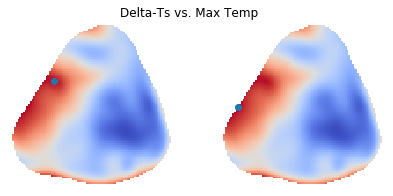

In [27]:
# Illustrate why delta-T is better
lbp = get_lbp(temps[0])
img = temp_diff(temps[0][0],temps[0][1],
                temps[0][2],temps[0][3], 
                viz=True, lbp_l=lbp[0], 
                lbp_lf=lbp[1], lbp_r=lbp[2],
                lbp_rf=lbp[3], ID=IDs[idx])

## Segmentation Features

In [28]:
# Create clahe object
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))

def snake_format(images):
    ''' 
    Put images into a format suitable for the Snake package:
        - Add a small value to zero values to ensure we still get
        numerical values when converting 0s to NaNs
        - Convert image pixels into a range from 0 to 255
        - Put them in the uint8 format
        - Apply CLAHE
    
    Parameters
    ----------
    images: numpy array
        4 temperature arrays for each exploration
        
    Returns
    -------
    therm: A numpy array of snake-formatted images
    '''
    new_images = []
    # Find max and min
    gl_min = np.nanmin(np.array(images))
    gl_max =  np.nanmax(np.array(images))
    for image in images:
        # Add small numeric values
        image = image - np.nanmin(image)+0.08
        image = np.nan_to_num(image/np.nanmax(image))
        # Apply clahe
        image = clahe.apply(np.asarray(image*255, dtype=np.uint8))
        image[image==4] = 0
        new_images.append(image)
    return new_images


def plot_res(images, masks, pid):
    ''' Plot images with the corresponding masks and the PID.
    
    Parameters
    ----------
    images: numpy array
        4 temperature arrays for each exploration
    masks: numpy array
        4 binary mask arrays for each exploration
    pid: string
        Patient identification number
        
    Returns
    -------
    therm: A numpy array of snake-formatted images
    '''
    # Put them into the order that corresponds to raw images
    fig, ax = plt.subplots(1, 4,figsize=(12,8))
    titles = ['left', 'left-front', 'right', 'right-front']
    for i in range(len(images)):
        # Plot images
        images[i][images[i]==0]=np.nan
        ax[i].imshow(masks[i]) 
        ax[i].set_title(titles[i])
        ax[i].imshow(images[i], alpha=0.8)
        ax[i].axis('off')
    plt.show()

In [29]:
def erode_masks(image, segments, 
                random_walk=False):
    ''' Get final segmented images (0-1 masks) by applying erosion. 
    
    Parameters
    ----------
    image: numpy array
        Temperature array for each exploration
    segments: numpy array
        Binary vascular segments for each exploration
    random_walk: bool
        Indicator of whether to use random_walker algorithm
        
    Returns
    -------
    Eroded masks
    '''
    kernel = np.ones((2, 2), np.uint8)
    if random_walk:
        segments = np.where(segments == 2, True,False)

    segments[np.isnan(segments)]=0
    # Erode masks to make sure we're not covering edges
    segments = cv2.erode(segments.astype('uint8'), 
                         kernel, iterations = 3).astype('bool')
    return np.where(segments==0, np.nan, 1)
    

def get_random(image, erode=False):
    ''' Get random walker segmented images. 
    
    Parameters
    ----------
    image: numpy array
        Temperature array for each exploration
    erode: bool
        Indicator of whether to erode images
        
    Returns
    -------
    Random walker segmentations
    '''
    markers = np.zeros(image.shape, dtype=np.uint)
    markers[image<0.99*(np.max(image))] = 1
    markers[image>0.60*(np.max(image))] = 2

    # Run random walker algorithm
    segments = seg.random_walker(image, markers, 
                                 beta=10, mode='bf')
    return erode_masks(image, segments, True)


def get_masks(temps, func=get_random):
    ''' Combine preprocessing and segmentation. 
    
    Parameters
    ----------
    temps: numpy array
        4 temperature arrays for each exploration
    func: function
        Segmentation function to use
        
    Returns
    -------
    Preprocessed and segmented masks
    '''
    new_temps = snake_format([temps[0], temps[1], 
                              temps[2], temps[3]])
    return [func(temp) for temp in new_temps]

In [30]:
def get_prop(image, function):
    ''' 
    Get the proportion of the image covered by the mask. 
    
    Parameters
    ----------
    image: numpy array
        Temperature array for each exploration
    function: function
        Segmentation function to use
        
    Returns
    -------
    Area of increased vascularization in %
    '''
    # Find segmented vascular areas
    vasc = function(image) 
    # Turn zeros to nans
    image = image.astype('float')
    image[image==0] = np.nan
    # Return the proportion
    return np.count_nonzero(~np.isnan(vasc))/np.count_nonzero(~np.isnan(image))

In [31]:
def vasc_score(temps_l, temps_lf, 
              temps_r, temps_rf, 
              function = get_random):
    ''' Calculate vascularity as defined in Gonzalez (2011). 
    
    Parameters
    ----------
    temps_l: numpy array
         Temperature array of the left image
    temps_lf: numpy array
         Temperature array of the left-front image
    temps_r: numpy array
         Temperature array of the right image
    temps_rf: numpy array
         Temperature array of the right-front image
    function: function
         Segmentation function to use
        
    Returns
    -------
    Vascularity score on a scale from 1 to 4
    '''
    new_temps = snake_format([temps_l, temps_lf, 
                              temps_r, temps_rf])
    left = get_prop(new_temps[0], function)
    left += get_prop(new_temps[1],function)
    left /= 2
    
    right = get_prop(new_temps[2], function)
    right += get_prop(new_temps[3], function)
    right /= 2
    
    # Experimentally found values that:
    # 1) have high correlation to researcher's scores
    # 2) correspond to the population distribution 
    # 3) were manually checked by the score developer
    if left<0.46 and right<0.46:
        return 1
    elif np.abs(left-right) < 0.2:
        return 2
    elif left>0.57 or right>0.57:
        return 4
    else:
        return 3

In [32]:
# Get vascularity scores
vascularity = [vasc_score(temps_l=temp[0], 
                   temps_lf=temp[1], 
                   temps_r=temp[2], 
                   temps_rf=temp[3]) for temp in temps]

blind_vascularity = [vasc_score(temps_l=temp[0], 
                   temps_lf=temp[1], 
                   temps_r=temp[2], 
                   temps_rf=temp[3]) for temp in blind_temps]


vascularity = pd.DataFrame({'IDs': IDs, 'vasc': vascularity})
df_full = pd.merge(df_full, vascularity, how="left", on='IDs')

blind_vascularity = pd.DataFrame({'IDs': blind_IDs, 'vasc': blind_vascularity})
df_blind = pd.merge(df_blind, blind_vascularity, how="left", on='IDs')

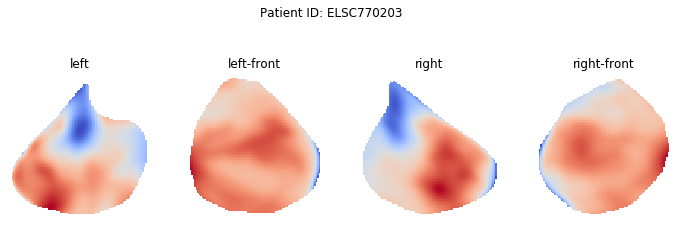

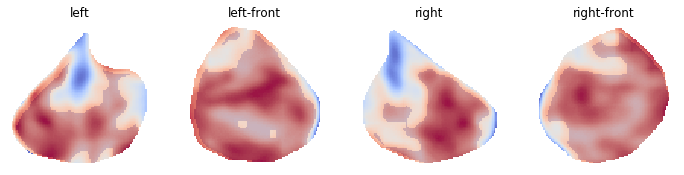

In [33]:
# Plot segmented explorations
plot_exp(temps[idx], IDs[idx])
new_temps = snake_format([temps[idx][0],
                          temps[idx][1],
                          temps[idx][2],
                          temps[idx][3]])
images = [temp for temp in new_temps]
labels = [get_random(image) for image in images]
images = [image.astype('float') for image in images]
plot_res(images, labels, IDs[idx])

## Create Datasets

In [34]:
df_train = df_full[df_full['IDs'].isin(X_train.index.values)]
df_train.index = X_train.index.values
df_train = df_train.drop(columns=['IDs'])

df_test = df_full[df_full['IDs'].isin(X_test.index.values)]
df_test.index = X_test.index.values
df_test = df_test.drop(columns=['IDs'])

df_val = df_full[df_full['IDs'].isin(X_val.index.values)]
df_val.index = X_val.index.values
df_val = df_val.drop(columns=['IDs'])

df_blind.index = blind_IDs
df_blind = df_blind.drop(columns=['IDs'])

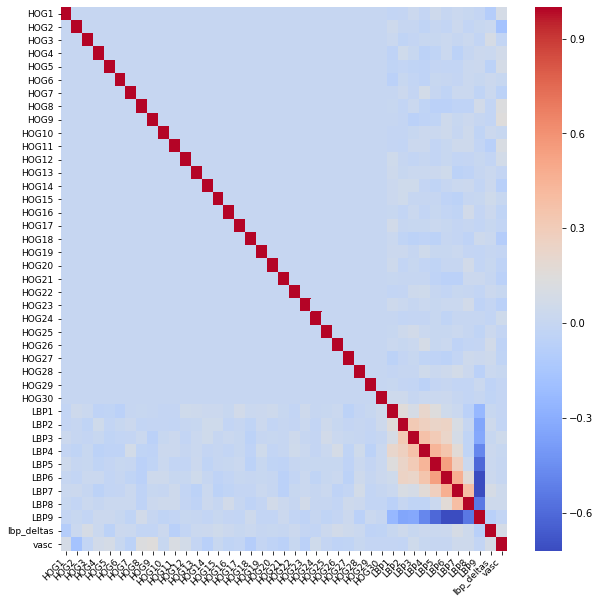

In [35]:
# Analyze Correlation ( HOGs are orthogonal)
fig = plt.figure(figsize=(10,10))
ax = sns.heatmap(df_train.corr().round(decimals=2),
                 annot=False, cmap='coolwarm')
plt.xticks(fontsize=12,rotation=45,ha='right')
plt.yticks(fontsize=12)
plt.xlabel("")
plt.ylabel("")
plt.tick_params(labelsize=9)
plt.show()

In [36]:
# Example dataset
df_train.head()

,HOG1,HOG2,HOG3,HOG4,HOG5,HOG6,HOG7,HOG8,HOG9,HOG10,...,LBP2,LBP3,LBP4,LBP5,LBP6,LBP7,LBP8,LBP9,lbp_deltas,vasc
RADL820324,-1.371565,0.807489,-2.254251,1.007360,-0.092994,0.657385,0.221389,1.180854,-0.246951,-1.301451,...,-0.000508,-0.005201,-0.017571,0.000935,0.015002,0.034770,-0.010275,-0.022954,1.370464,2
SAMG850909,-1.502152,0.069987,-1.418895,-1.127319,0.605097,2.513478,0.396302,-0.151165,0.435440,0.632690,...,0.008000,0.001210,0.020038,0.032645,-0.010229,-0.012338,0.025949,-0.064900,1.065163,1
DICA971030,-1.940585,1.966867,-0.374716,-2.169323,-0.599983,0.120350,-0.436862,0.850089,0.000835,-0.416110,...,-0.008643,0.004786,0.008963,0.010326,-0.000403,0.035435,0.046510,-0.085482,0.530415,1
MEMR750609,-1.034237,0.335155,-1.815421,-0.181717,-0.327546,-1.029567,-1.374261,0.634037,-2.032316,0.246734,...,0.018160,-0.003516,0.017777,-0.004809,-0.003407,-0.008001,0.051946,-0.090774,0.454762,1
ROGC760606,-0.461621,1.150660,-1.282628,-1.273359,1.193648,0.883413,1.095596,0.523819,-0.865364,0.436860,...,-0.003728,-0.000835,-0.000466,-0.005437,0.021436,-0.007382,-0.021584,0.047075,1.345772,2


## Feature Selection with SHAP

SHAP values are used for iterative feature selection process.

In [37]:
# Get automated thermal score values
TS_train = (df_train['lbp_deltas'].values + df_train['vasc'].values).reshape(-1,1)
TS_test = (df_test['lbp_deltas'].values + df_test['vasc'].values).reshape(-1,1)

# Get different subsets of engineered features
new_train = df_train.drop(columns=['lbp_deltas', 'vasc'])
new_test = df_test.drop(columns=['lbp_deltas', 'vasc'])

hog_train = df_train.filter(regex=best_kernel)
hog_test = df_test.filter(regex=best_kernel)

lbp_train = df_train.filter(regex='LBP')
lbp_test = df_test.filter(regex='LBP')

In [38]:
# Scale features from 0 to 1 (SHAP requirement)
x = df_train
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
shap_train = pd.DataFrame(x_scaled, columns=df_train.columns)

x = df_val
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
shap_val = pd.DataFrame(x_scaled, columns=df_val.columns)

model = LogisticRegression()
model.fit(shap_train, y_train_bi)

# Train shap explainer
explainer = shap.KernelExplainer(model.predict_proba, 
                                 shap.kmeans(shap_train, 10))

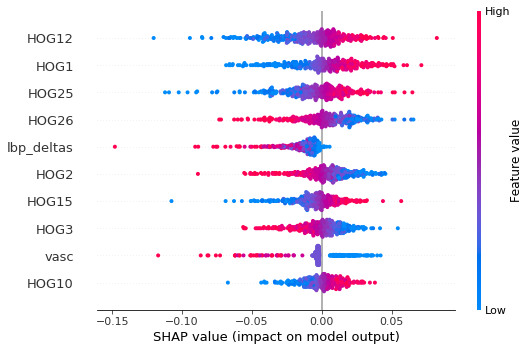

In [39]:
# Summary plot for the validation set (top-10 features)
all_shap_values = np.asarray(explainer.shap_values(shap_val))
shap.summary_plot(all_shap_values[0], shap_val, 
                  feature_names=shap_val.columns, 
                  max_display=10)

In [40]:
# Sort features in the order of their importance
vals= np.abs(all_shap_values[0]).mean(0)
feature_importance = pd.DataFrame(list(zip(shap_train.columns, vals)),
                                  columns=['col_name', 'feat_imp'])
feature_importance.sort_values(by=['feat_imp'], 
                               ascending=False,
                               inplace=True)

In [41]:
max_auc=0
final = 0
for i in range(len(feature_importance)):
    b=i+1
    sh_train = df_train[feature_importance.col_name.values[:b]]
    sh_val = df_val[feature_importance.col_name.values[:b]]
    candidate = performance(sh_train, y_train_bi, sh_val, y_val_bi, detailed = False, title='SHAP')
    if max_auc < candidate:
        max_auc, final = candidate, b

print('Num features: ', final, 'out of', len(feature_importance))
print(np.round(max_auc, 2))

Num features:  9 out of 41
0.83


In [42]:
# Subset selected features
df_train = df_train[feature_importance.col_name.values[:final]]
df_test = df_test[feature_importance.col_name.values[:final]]
df_val = df_val[feature_importance.col_name.values[:final]]
df_blind = df_blind[feature_importance.col_name.values[:final]]

## Algorithm Selection

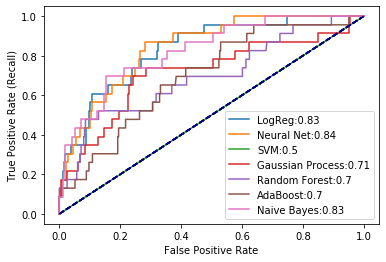

In [43]:
names = ['LogReg', 'Neural Net', 
         'SVM', 'Gaussian Process',
         'Random Forest',
         'AdaBoost', 'Naive Bayes']

classifiers = [
    LogisticRegression(),
    MLPClassifier(alpha=1, max_iter=1000),
    SVC(C=0.025),
    GaussianProcessClassifier(),
    RandomForestClassifier(max_depth=5, 
                           n_estimators=10, 
                           max_features=1),
    AdaBoostClassifier(),
    GaussianNB()]

for i in range(len(classifiers)):
    performance(df_train, y_train_bi, df_val, 
                y_val_bi, detailed = True,
                title=names[i], model=classifiers[i])

## Hyperparameter Tuning

I picked three best performing models - LogReg, Neural Net, and Naive Bayes for consideration.
The Naive Bayes model doesn't have any hyperparameters to tune, so I used grid search only for the first two models.

In [44]:
# Parameter grods for LR and MLP
param_grids = [{'penalty': ['l1', 'l2'],
                'solver': ['liblinear'],
                'C':np.logspace(-3,3,7)},
               {'hidden_layer_sizes': [(50,50,50), 
                                       (50,100,50), 
                                       (100,)],
                'activation': ['tanh', 'relu'],
                'solver': ['sgd', 'adam'],
                'alpha': [0.0001, 0.001, 0.05, 0.1],
                'learning_rate': ['constant','adaptive']}] 

In [45]:
# Set the parameters by cross-validation
from sklearn.model_selection import GridSearchCV
scores = ['precision', 'recall']
best_models = []
from sklearn.metrics import classification_report
for i in [0,1]:
    print(names[i], i)
    for score in scores:
        print('Optimizing hyperparameters for %s \n' % score)

        clf = GridSearchCV(
            classifiers[i], 
            param_grids[i], 
            scoring='%s_macro'%score
        )
        clf.fit(df_train, y_train_bi)
        best_models.append(clf.best_params_)
        print('Detailed classification report:\n')
        y_true, y_pred = y_val_bi, clf.predict(df_val)
        print(classification_report(y_true, y_pred))

LogReg 0
Optimizing hyperparameters for precision 

Detailed classification report:

              precision    recall  f1-score   support

           0       0.94      1.00      0.97       349
           1       0.67      0.09      0.15        23

   micro avg       0.94      0.94      0.94       372
   macro avg       0.80      0.54      0.56       372
weighted avg       0.93      0.94      0.92       372

Optimizing hyperparameters for recall 

Detailed classification report:

              precision    recall  f1-score   support

           0       0.94      1.00      0.97       349
           1       0.67      0.09      0.15        23

   micro avg       0.94      0.94      0.94       372
   macro avg       0.80      0.54      0.56       372
weighted avg       0.93      0.94      0.92       372

Neural Net 1
Optimizing hyperparameters for precision 

Detailed classification report:

              precision    recall  f1-score   support

           0       0.94      0.95      0.95 

In [46]:
# Naive Bayes
print('Naive Bayes')
clf = GaussianNB()
clf.fit(df_train, y_train_bi)
y_true, y_pred = y_val_bi, clf.predict(df_val)
classification_report(y_true, y_pred)

Naive Bayes
              precision    recall  f1-score   support

           0       0.94      1.00      0.97       349
           1       1.00      0.09      0.16        23

   micro avg       0.94      0.94      0.94       372
   macro avg       0.97      0.54      0.57       372
weighted avg       0.95      0.94      0.92       372



In [47]:
# Print final model parameters
fin_model = MLPClassifier(**best_models[3])
fin_model

MLPClassifier(activation='tanh', alpha=0.05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(50, 100, 50), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

## Final Analysis on the Test Set

                   pre       rec       spe        f1       geo       iba       sup

          0       0.95      0.85      0.35      0.90      0.55      0.31       350
          1       0.14      0.35      0.85      0.20      0.55      0.28        23

avg / total       0.90      0.82      0.38      0.86      0.55      0.31       373

                   pre       rec       spe        f1       geo       iba       sup

   Negative       0.94      0.98      0.09      0.96      0.29      0.09       350
   Positive       0.22      0.09      0.98      0.12      0.29      0.08        23

avg / total       0.90      0.92      0.14      0.91      0.29      0.09       373



0.6965217391304348

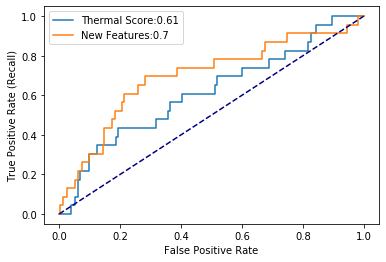

In [48]:
# Evaluate performance
min_max_scaler = preprocessing.MinMaxScaler()
TS_scaled = min_max_scaler.fit_transform(TS_test)

# Automated thermal score
print(metrics.classification_report_imbalanced(y_test_bi, np.round(TS_scaled)))
fpr, tpr, thresholds = roc_curve(y_test_bi, TS_scaled)
plt.plot(fpr, tpr, label='Thermal Score' + ':'+ str(np.round(auc(fpr,tpr),2)))

# Machine learning model
performance(df_train, y_train_bi, df_test, 
            y_test_bi, detailed = True, 
            title='New Features', 
            report=True, model=fin_model)

In [49]:
# Save data
os.chdir('notebooks/Capstone')
df_train['BIRADS'] = y_train
df_test['BIRADS'] = y_test
df_val['BIRADS'] = y_val
df_train.to_csv('train_data.csv')
df_test.to_csv('test_data.csv')
df_val.to_csv('val_data.csv')
df_blind.to_csv('blind_data.csv')

In [50]:
# Save model parameters
f = open("params.pkl","wb")
pickle.dump(best_models[3],f)
f.close()